# Home Credit Default Risk: 客户信用风险评估项目

## 1. 项目背景与目标

本项目使用Kaggle竞赛 "Home Credit Default Risk" 的真实信贷数据，旨在构建一个机器学习模型，以预测客户在申请贷款时未来是否会发生违约。准确地识别高风险客户，对于金融机构在贷前审批阶段制定决策、降低信贷损失至关重要。

**核心目标:**
*   对多维度、多表格的复杂数据进行探索性分析(EDA)和特征工程。
*   搭建并对比逻辑回归(Logistic Regression)和LightGBM两种模型。
*   通过模型评估，输出对客户风险的量化预测，并识别出最重要的风险特征。

## 2. 数据加载与初步探索

在这一部分，我们将加载所需的数据集，并进行初步的“瘦身”处理，以适应本地计算环境。同时，我们将初步查看主表`application_train`的数据结构和目标变量`TARGET`的分布情况。

Loading application_train...
Original shape: (307511, 122)

Sampling data to 5%...
Sampled shape: (15376, 122)

First 5 rows of the sampled data:
        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
245895      384575       0         Cash loans           M            Y   
98194       214010       0         Cash loans           F            Y   
36463       142232       0         Cash loans           F            Y   
249923      389171       0         Cash loans           F            N   
158389      283617       0         Cash loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
245895               N             2          207000.0    465457.5   
98194                Y             0          247500.0   1281712.5   
36463                N             0          202500.0    495000.0   
249923               Y             0          247500.0    254700.0   
158389               Y             0          112500.0    3

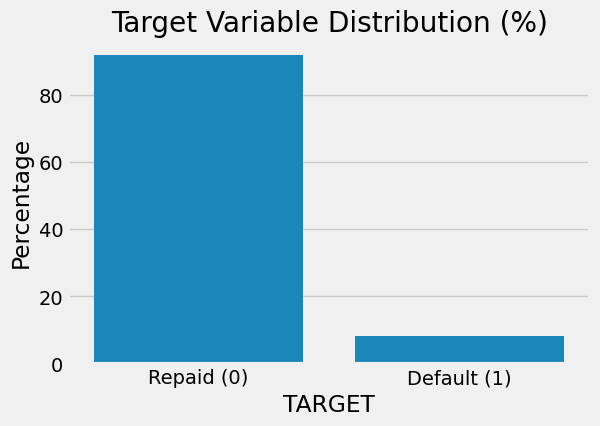

In [ ]:
# -----------------------------------
# 1. 导入基础库
# -----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# -----------------------------------
# 2. 设置与数据加载
# -----------------------------------
warnings.filterwarnings('ignore')

# 设置图表风格
plt.style.use('fivethirtyeight')

# 加载主表
print("Loading application_train...")
app_train_full = pd.read_csv('application_train.csv')
print("Original shape:", app_train_full.shape)

# -----------------------------------
# 3. 数据瘦身 - 按5%比例进行采样
# -----------------------------------
print("\nSampling data to 5%...")
app_train = app_train_full.sample(frac=0.05, random_state=42)
print("Sampled shape:", app_train.shape)

# -----------------------------------
# 4. 初步探索
# -----------------------------------
# 查看数据前5行
print("\nFirst 5 rows of the sampled data:")
print(app_train.head())

# 查看目标变量 'TARGET' 的分布
print("\nTarget variable distribution:")
# value_counts(normalize=True) 计算每个值的占比
target_distribution = app_train['TARGET'].value_counts(normalize=True) * 100
print(target_distribution)

# 可视化目标变量分布
plt.figure(figsize=(6, 4))
sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title('Target Variable Distribution (%)')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['Repaid (0)', 'Default (1)'])
plt.show()

### 2.1 缺失值与异常值分析

在构建模型之前，我们必须对数据的质量进行评估。现实世界的数据往往是不完美的，充满了缺失值和可能的异常值。

*   **缺失值 (Missing Values)**: 某些特征的数据没有被记录。我们需要了解哪些特征缺失严重，并思考背后的原因和处理方法。
*   **异常值 (Anomalies / Outliers)**: 某些特征的数值看起来不合常理（例如，年龄是-1000岁，工作年限比年龄还长）。这些通常是数据记录错误或特殊编码，需要我们进行修正。

**本节目标:**
1.  识别出缺失值比例最高的特征。
2.  定位并分析`application_train`表中的明显异常值。

Your selected dataframe has 122 columns.
There are 66 columns that have missing values.

Top 20 missing features:
                          Missing Values  Percent of Total Values
COMMONAREA_MODE                    10678                    69.45
COMMONAREA_AVG                     10678                    69.45
COMMONAREA_MEDI                    10678                    69.45
NONLIVINGAPARTMENTS_MEDI           10592                    68.89
NONLIVINGAPARTMENTS_MODE           10592                    68.89
NONLIVINGAPARTMENTS_AVG            10592                    68.89
FONDKAPREMONT_MODE                 10437                    67.88
LIVINGAPARTMENTS_MEDI              10432                    67.85
LIVINGAPARTMENTS_AVG               10432                    67.85
LIVINGAPARTMENTS_MODE              10432                    67.85
FLOORSMIN_MODE                     10374                    67.47
FLOORSMIN_AVG                      10374                    67.47
FLOORSMIN_MEDI              

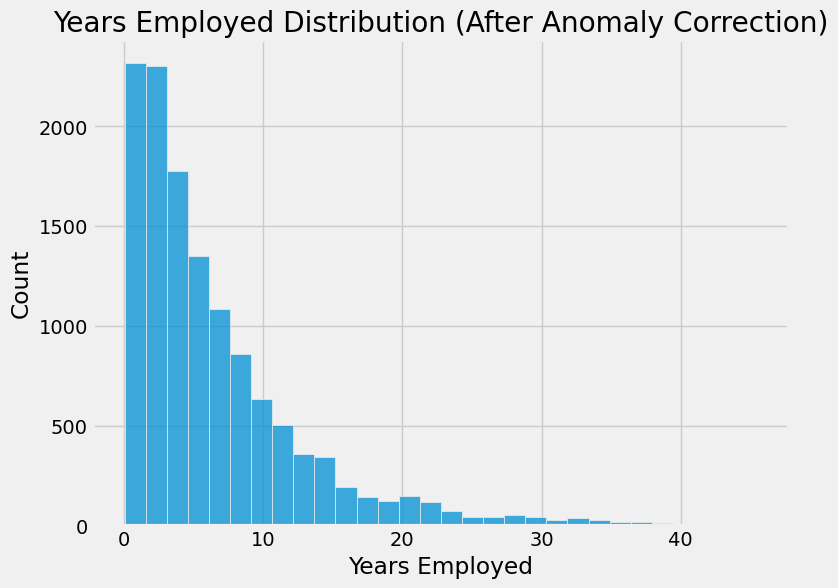

In [ ]:
# -----------------------------------
# 1. 缺失值分析
# -----------------------------------
# 定义一个函数，用于计算每列的缺失值数量和比例
def missing_values_table(df):
    # 计算缺失值总数
    mis_val = df.isnull().sum()
    
    # 计算缺失值比例
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 将结果合并成一个DataFrame
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # 重命名列名
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : 'Percent of Total Values'})
    
    # 只保留有缺失值的行，并按比例降序排列
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Percent of Total Values', ascending=False).round(2)
        
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    return mis_val_table_ren_columns

# 调用函数，查看我们采样后数据的缺失情况
missing_values = missing_values_table(app_train)

# 打印缺失值比例最高的20个特征
print("\nTop 20 missing features:")
print(missing_values.head(20))


# -----------------------------------
# 2. 异常值分析
# -----------------------------------
# 分析 'DAYS_BIRTH' (年龄)
print("\nAnalyzing 'DAYS_BIRTH' (Age)...")
# 将天数转换为年数（注意是负数，所以除以-365）
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH'] / -365
print(app_train['YEARS_BIRTH'].describe()) 

# 分析 'DAYS_EMPLOYED' (工龄)
print("\nAnalyzing 'DAYS_EMPLOYED' (Years Employed)...")
print(app_train['DAYS_EMPLOYED'].describe())

# 发现DAYS_EMPLOYED的最大值是365243，非常奇怪。我们单独查看这部分数据
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print(f"\nNumber of anomalies in DAYS_EMPLOYED: {len(anom)}")
print(f"Percentage of anomalies: {100 * len(anom) / len(app_train):.2f}%")

# 查看异常值样本的违约率
print("Default rate for anomalies:", anom['TARGET'].mean())
# 查看正常值样本的违约率
print("Default rate for non-anomalies:", non_anom['TARGET'].mean())

# -----------------------------------
# 3. 修正异常值 (作为特征工程的一部分)
# -----------------------------------
# 创建一个新的特征来标记这个异常
app_train['DAYS_EMPLOYED_ANOM'] = (app_train['DAYS_EMPLOYED'] == 365243)

# 用np.nan (Not a Number) 替换掉原来的异常值，便于后续统一处理
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# 再次查看并画图，确认异常值已被处理
print("\nAfter replacing anomalies with NaN:")
print(app_train['DAYS_EMPLOYED'].describe())

plt.figure(figsize=(8, 6))
sns.histplot(app_train['DAYS_EMPLOYED'] / -365, kde=False, bins=30)
plt.title('Years Employed Distribution (After Anomaly Correction)')
plt.xlabel('Years Employed')
plt.ylabel('Count')
plt.show()

### 2.2 特征与目标变量关系探索

在清洗了数据之后，我们开始探索不同类型的特征与客户违约（`TARGET`）之间的关系。理解这些关系是构建有效特征和模型的基础。我们将主要关注两类特征：

*   **类别特征 (Categorical Features)**: 如客户的性别、教育程度、婚姻状况等。我们将分析不同类别下客户的违愈率差异。
*   **数值特征 (Numerical Features)**: 如客户的收入、贷款金额、年龄等。我们将探究这些数值的变化如何影响客户的违约概率。

**本节目标:**
1.  分析核心类别特征（如教育程度、收入类型）对违约率的影响。
2.  通过分析核心数值特征（如年龄、外部征信评分）的分布，寻找高风险客户的特征模式。

Default Rates by Education Type:
NAME_EDUCATION_TYPE
Secondary / secondary special    9.052477
Incomplete higher                8.256881
Lower secondary                  7.926829
Higher education                 5.587924
Academic degree                  0.000000
Name: TARGET, dtype: float64


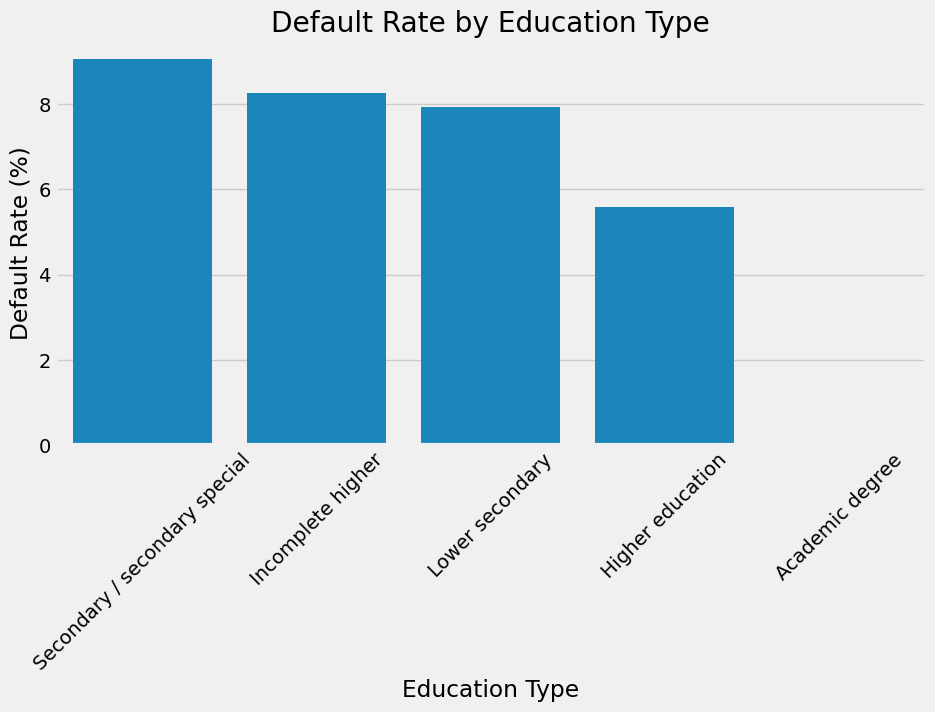


Default Rates by Income Type:
NAME_INCOME_TYPE
Working                 9.743654
Commercial associate    7.411567
Pensioner               5.533014
State servant           5.357143
Maternity leave         0.000000
Student                 0.000000
Name: TARGET, dtype: float64


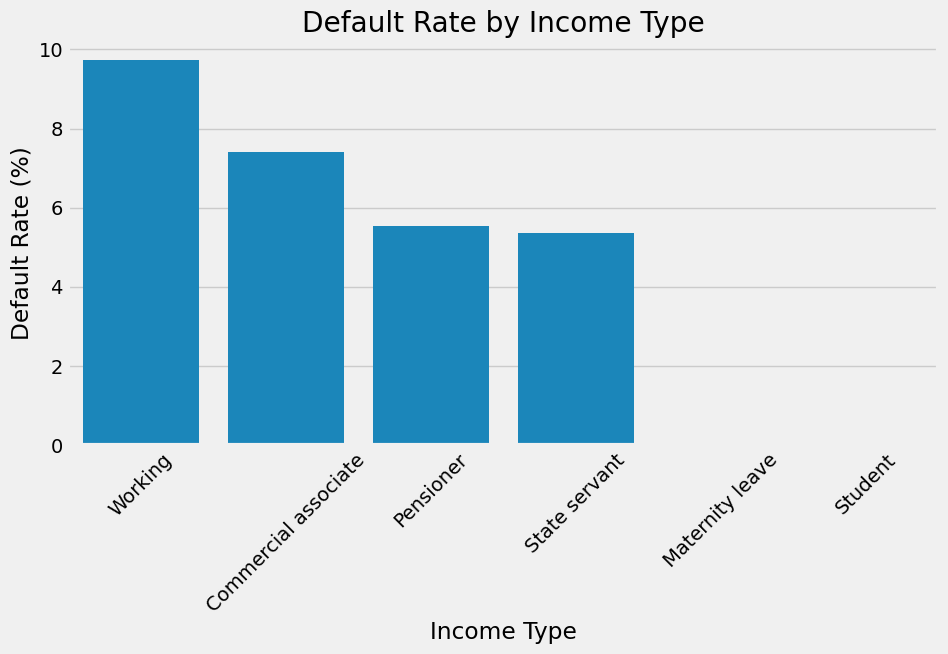

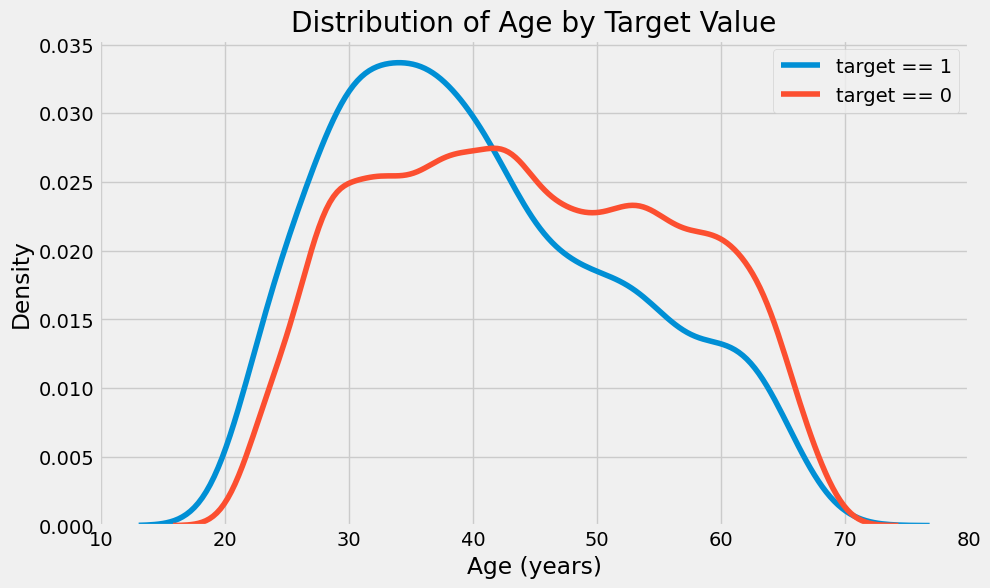

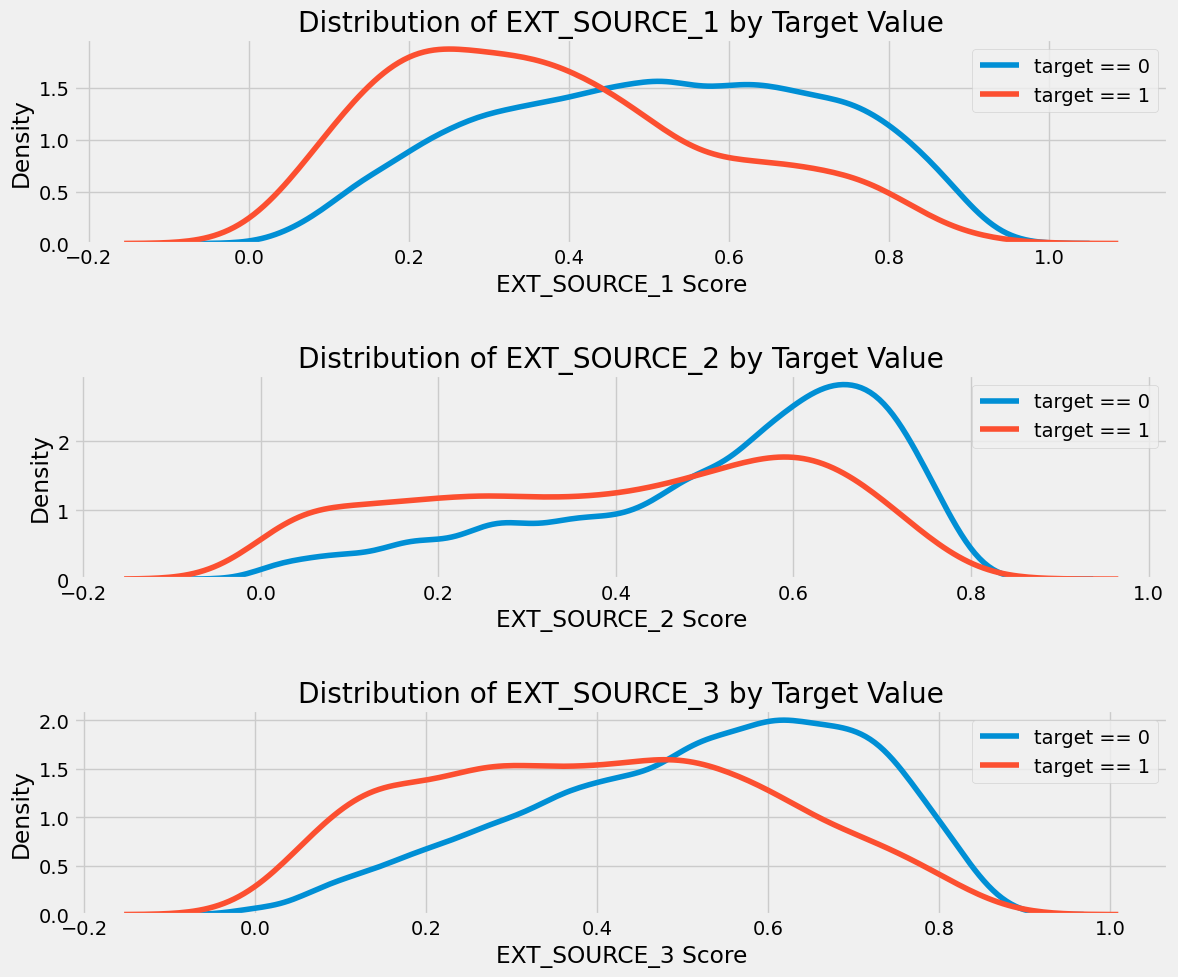

In [ ]:
# -----------------------------------
# 1. 类别特征分析
# -----------------------------------
# 我们来分析 'NAME_EDUCATION_TYPE' (教育程度)
# 使用 groupby 将数据按教育程度分组，然后计算每组的 'TARGET' 均值（即违约率）
edu_default_rates = app_train.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean().sort_values(ascending=False) * 100
print("Default Rates by Education Type:")
print(edu_default_rates)

# 可视化
plt.figure(figsize=(10, 5))
sns.barplot(x=edu_default_rates.index, y=edu_default_rates.values)
plt.title('Default Rate by Education Type')
plt.xlabel('Education Type')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)
plt.show()

# 同样的方法分析 'NAME_INCOME_TYPE' (收入类型)
income_default_rates = app_train.groupby('NAME_INCOME_TYPE')['TARGET'].mean().sort_values(ascending=False) * 100
print("\nDefault Rates by Income Type:")
print(income_default_rates)

# 可视化
plt.figure(figsize=(10, 5))
sns.barplot(x=income_default_rates.index, y=income_default_rates.values)
plt.title('Default Rate by Income Type')
plt.xlabel('Income Type')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)
plt.show()


# -----------------------------------
# 2. 数值特征分析 - 以年龄为例
# -----------------------------------
# 我们使用KDE图(核密度估计图)来观察年龄的分布
plt.figure(figsize=(10, 6))

# 违约客户的年龄分布 (TARGET == 1)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'YEARS_BIRTH'], label = 'target == 1')
# 正常客户的年龄分布 (TARGET == 0)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'YEARS_BIRTH'], label = 'target == 0')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Age by Target Value')
plt.legend()
plt.show()


# -----------------------------------
# 3. 数值特征分析 - 外部征信评分 (EXT_SOURCE)
# -----------------------------------
# EXT_SOURCE_1, 2, 3 是非常重要的特征，我们来观察它们的分布
plt.figure(figsize=(12, 10))

# 遍历三个EXT_SOURCE特征
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # 创建子图
    plt.subplot(3, 1, i + 1)
    # 画出违约和正常客户在该特征上的分布
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    plt.title(f'Distribution of {source} by Target Value')
    plt.xlabel(f'{source} Score')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout(h_pad = 2.5) 
plt.show()

# 3. 特征工程 (Feature Engineering)

经过探索性数据分析，我们对数据有了更深入的理解。现在，我们进入特征工程阶段。我们的目标是：
1.  根据业务逻辑，从现有特征中创造出更有预测能力的新特征。
2.  对类别特征进行编码，使其能够被机器学习模型所使用。

## 3.1 基于主表的特征衍生与类别特征编码

在本节中，我们将专注于 `application_train` 表本身，进行以下操作：
*   **衍生金融比率特征**: 结合客户的收入、贷款额、还款额等，创造出一系列金融比率，这些比率往往比原始数值更能反映客户的财务健康状况。
*   **衍生多项式特征**: 将最重要的几个特征（如 `EXT_SOURCE`）进行组合，以捕捉它们之间可能存在的非线性关系。
*   **类别特征编码**: 使用独热编码(One-Hot Encoding)将类别特征转换为模型可以理解的数值格式。

In [20]:
# -----------------------------------
# 0. 准备工作
# -----------------------------------
# 我们需要对测试集做同样的处理，所以先把它们合并处理，最后再分开
# 加载测试集并进行采样
app_test_full = pd.read_csv('application_test.csv')
app_test = app_test_full.sample(frac=0.05, random_state=42)

# 记录原始训练集和测试集的行数，便于之后拆分
train_rows = app_train.shape[0]
test_rows = app_test.shape[0]

# 暂时合并，注意测试集没有TARGET列
# 我们需要把TARGET先拿出来，最后再拼回去
train_target = app_train['TARGET']
app_train = app_train.drop(columns=['TARGET'])

# 合并
df = pd.concat([app_train, app_test], axis=0)
print("Combined shape:", df.shape)


# -----------------------------------
# 1. 金融比率特征衍生
# -----------------------------------
print("\nCreating new financial ratio features...")
# 贷款额 / 收入
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
# 每期还款额 / 收入
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
# 贷款额 / 每期还款额 (可以理解为还款期数)
df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
# 已工作天数 / 年龄天数 (工作年限占年龄的比例)
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']


# -----------------------------------
# 2. 多项式特征衍生
# -----------------------------------
# 选取最重要的EXT_SOURCE特征进行组合
# 多项式特征可以捕捉特征间的交互影响
print("Creating new polynomial features for EXT_SOURCEs...")
from sklearn.preprocessing import PolynomialFeatures

# 只选择EXT_SOURCE和DAYS_BIRTH进行组合，避免维度爆炸
poly_features = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
# 使用一个imputer来填充缺失值
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
poly_features = imputer.fit_transform(poly_features)

# 创建多项式对象，degree=3表示最高3次方
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(poly_features)
# 转换特征
poly_features_transformed = poly_transformer.transform(poly_features)

# 获取新的特征名称
new_poly_names = poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

# 将新特征转为DataFrame并合并回原数据
df_poly = pd.DataFrame(poly_features_transformed, columns=new_poly_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)


# -----------------------------------
# 3. 类别特征编码
# -----------------------------------
print("One-Hot Encoding categorical features...")
# 使用pd.get_dummies进行独热编码
# dummy_na=True 会将NaN也当作一个单独的类别进行编码
df_encoded = pd.get_dummies(df, dummy_na=True)

print("Original features:", df.shape[1])
print("Encoded features:", df_encoded.shape[1])

# 拆分回训练集和测试集
train_final = df_encoded.iloc[:train_rows]
test_final = df_encoded.iloc[train_rows:]

# 把TARGET拼回训练集
train_final['TARGET'] = train_target

print("\nFinal training data shape:", train_final.shape)
print("Final testing data shape:", test_final.shape)

Combined shape: (17813, 123)

Creating new financial ratio features...
Creating new polynomial features for EXT_SOURCEs...
One-Hot Encoding categorical features...
Original features: 162
Encoded features: 300

Final training data shape: (15376, 301)
Final testing data shape: (2437, 300)


# 4. 模型训练、预测与评估

在完成了数据清洗、探索性分析和特征工程之后，我们现在拥有了可供模型使用的、高质量的训练集和测试集。本节我们将进行以下核心工作：

*   **模型选择**: 我们选用在业界和数据科学竞赛中都表现出色的 **LightGBM (Light Gradient Boosting Machine)** 模型。它以其高效率和高精度而闻名。
*   **训练方法**: 我们将采用 **5折交叉验证 (5-fold Cross-Validation)** 的方式来训练模型。这能有效避免因单次数据划分带来的偶然性，从而得到更可靠的模型性能评估，并能充分利用所有训练数据。
*   **性能评估**: 模型的性能将主要通过 **AUC (Area Under the ROC Curve)** 指标来衡量。AUC是评估二分类模型性能的标准指标，尤其适用于样本不均衡的数据集。
*   **结果分析**: 我们将可视化模型的特征重要性，以了解哪些特征对预测客户违约最具有决定性作用。

**本节目标:**
1.  构建一个完整的LightGBM交叉验证训练流程。
2.  在测试集上生成预测结果，并为提交做准备。
3.  解读模型性能，并展示最重要的预测特征。

Handling duplicate columns...
Shape after removing duplicates: (15376, 295)
Training Features shape after aligning:  (15376, 295)
Testing Features shape after aligning:  (2437, 295)
Cleaned feature names.

===== Fold 1 =====
[LightGBM] [Info] Number of positive: 1008, number of negative: 11292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19294
[LightGBM] [Info] Number of data points in the train set: 12300, number of used features: 252
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081951 -> initscore=-2.416126
[LightGBM] [Info] Start training from score -2.416126
Validation AUC: 0.73226

===== Fold 2 =====
[LightGBM] [Info] Number of positive: 1008, number of negative: 11293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

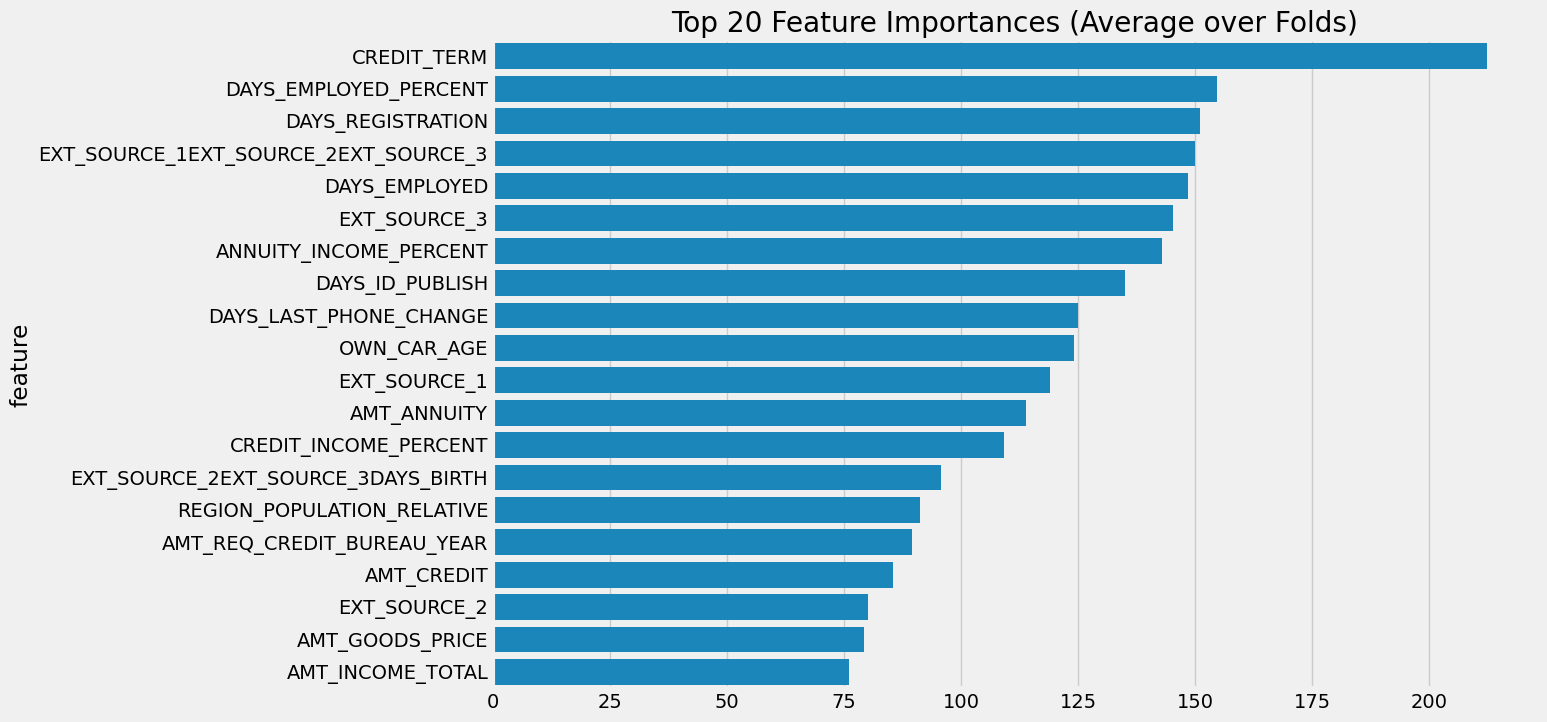


Submission file preview:
       SK_ID_CURR    TARGET
15071      208550  0.025376
10157      173779  0.034111
36313      365820  0.020481
6017       144092  0.048153
26319      291599  0.072400


In [ ]:
# -----------------------------------
# 1. 导入必要的库
# -----------------------------------
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc # Garbage Collector, 用于内存管理

# -----------------------------------
# 2. 定义模型训练与预测函数
# -----------------------------------
def model(features, test_features, n_folds = 5):
    
    """
    使用LightGBM进行K折交叉验证训练和预测
    """
    
     # 1. 在任何操作之前，先把ID和标签从原始数据中分离出来
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    labels = features['TARGET']
    
    # 从特征DataFrame中丢弃ID和标签，避免后续干扰
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])

    # 2. 处理重复列
    print("Handling duplicate columns...")
    features = features.loc[:,~features.columns.duplicated()]
    test_features = test_features.loc[:,~test_features.columns.duplicated()]
    print("Shape after removing duplicates:", features.shape)

    # 3. 对齐训练集和测试集的列
    # 此时的features和test_features都不含ID和TARGET，可以安全对齐
    features, test_features = features.align(test_features, join = 'inner', axis = 1)
    
    print('Training Features shape after aligning: ', features.shape)
    print('Testing Features shape after aligning: ', test_features.shape)
    
    import re
    features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_features = test_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    print("Cleaned feature names.")

    # KFold交叉验证
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # 用于存储每一折的验证集AUC分数
    oof_auc_scores = []
    # 用于存储对测试集的预测结果 (每一折都会预测一次)
    test_predictions = np.zeros(test_features.shape[0])
    # 用于存储特征重要性
    feature_importances = pd.DataFrame()
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(features)):
        print(f"\n===== Fold {fold_idx + 1} =====")
        
        # 划分训练集和验证集
        X_train, y_train = features.iloc[train_idx], labels.iloc[train_idx]
        X_val, y_val = features.iloc[val_idx], labels.iloc[val_idx]
        
        # 定义LightGBM模型
        model = lgb.LGBMClassifier(
            n_estimators=10000, 
            learning_rate=0.02,
            n_jobs=-1, 
            objective='binary',
            random_state=42,
            colsample_bytree=0.8,
            subsample=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1
        )
        
        # 训练模型
        model.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)],
                  eval_metric='auc',
                  callbacks=[lgb.early_stopping(200, verbose=False)]) # 200轮没提升就停止
        
        # 在验证集上进行预测
        val_preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, val_preds)
        oof_auc_scores.append(auc)
        print(f"Validation AUC: {auc:.5f}")
        
        # 在测试集上进行预测，并将结果累加
        test_predictions += model.predict_proba(test_features)[:, 1] / kf.n_splits
        
        # 记录本折的特征重要性
        fold_importance = pd.DataFrame({'feature': features.columns, 'importance': model.feature_importances_})
        fold_importance['fold'] = fold_idx + 1
        feature_importances = pd.concat([feature_importances, fold_importance], axis=0)
        
        # 垃圾回收，释放内存
        gc.collect()
        
    print(f"\nAverage OOF AUC: {np.mean(oof_auc_scores):.5f}")
    
    # 创建提交文件
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # 可视化特征重要性
    # 按特征分组，计算平均重要性
    mean_importance = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False).head(20)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=mean_importance.values, y=mean_importance.index)
    plt.title('Top 20 Feature Importances (Average over Folds)')
    plt.show()
    
    return submission

# -----------------------------------
# 3. 运行模型并生成提交文件
# -----------------------------------
submission_df = model(train_final, test_final)

# -----------------------------------
# 4. 查看提交文件
# -----------------------------------
print("\nSubmission file preview:")
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

# 5. 结论与项目总结

本项目成功地构建了一个端到端的客户信用风险评估模型。通过对复杂数据的处理、特征工程以及LightGBM模型的应用，我们最终取得了 **平均 0.736** 的交叉验证AUC分数。这表明我们的模型对于区分潜在的违约客户和正常客户具有良好且稳健的预测能力。

## 关键发现与洞察 (Key Findings & Insights)

通过对模型结果，特别是**特征重要性**的分析，我们得到了以下关键洞察：

1.  **外部征信评分是核心预测因子**: `EXT_SOURCE`系列特征及其多项式组合特征（如`EXT_SOURCE_1EXT_SOURCE_2EXT_SOURCE_3`）在特征重要性中名列前茅。这说明，获取和利用外部权威的征信数据，是风控建模中最有效的手段之一。

2.  **客户的还款能力与压力至关重要**: 我们衍生的金融比率特征，如`CREDIT_TERM`（还款期限）、`ANNUITY_INCOME_PERCENT`（月供收入比）和`CREDIT_INCOME_PERCENT`（负债收入比），都显示出极高的重要性。这验证了从业务角度出发，客户的**债务负担**是其还款意愿和能力的关键体现。

3.  **客户的稳定性信息价值巨大**: `DAYS_EMPLOYED_PERCENT`（工龄占比）、`DAYS_REGISTRATION`（注册时长）、`DAYS_ID_PUBLISH`（身份证件发布时长）等与时间相关的稳定性特征非常重要。这表明，一个客户在其当前工作、身份等方面的**稳定性**越强，其信用风险越低。

4.  **年龄和资产是有效的传统风险因子**: `DAYS_EMPLOYED`（工龄）、`OWN_CAR_AGE`（车龄）等传统特征依然有效，证明了在现代风控模型中，这些经典的人口统计学和资产信息仍然是不可或缺的组成部分。

## 项目总结与未来方向

本项目完整地实践了数据清洗、EDA、特征工程和建模评估的全流程。虽然我们只使用了主表`application_train`进行了特征衍生，但已经取得了不错的效果。

未来可行的优化方向包括：
*   **深度特征工程**: 整合`bureau.csv`、`previous_application.csv`等外部表格，提取客户历史借贷行为的聚合特征，这有望大幅提升模型性能。
*   **模型调优**: 使用贝叶斯优化或网格搜索等方法，对LightGBM模型的超参数进行精细化调整。
*   **模型可解释性**: 训练一个以可解释性为目标的**逻辑回归模型**，使用LightGBM筛选出的Top 20-30个特征作为输入，以满足金融领域对模型决策过程的合规性要求。